In [1]:
import os
import torch
import numpy as np

import scanpy as sc
from anndata import AnnData

result_dir = "../edges/"
raw_type=False
use_edge=False

In [3]:
def read_data(sample,select=10,loss_threshold=10,exclude_same=True,normalize=False):
    results=torch.load(result_dir+"edges_"+sample+".pth")
    edges=results["attention_score"]
    # modify here
    if normalize:
        attention_score=torch.abs(torch.abs(results["attention_score"])/torch.sum(results["attention_score"],dim=-2,keepdim=True))
    else:
        attention_score=results["attention_score"]
        normalized_attention_score=torch.abs(torch.abs(results["attention_score"])/torch.sum(results["attention_score"],dim=-2,keepdim=True))
    print(attention_score.shape)
    position_x=results["position_x"]
    position_y=results["position_y"]
    cell_type_name=results["cell_type_name"]
    loss1=results["loss_all"].cpu()
    
    B,N=position_x.shape
    loss1=loss1.unsqueeze(dim=-1).repeat(1,select).reshape(-1).numpy()
    
    cell_type_target=[cell_type_name[i][0] for i in range(len(cell_type_name))]
    
    if normalize:
        indices=torch.topk(torch.sum(attention_score,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(attention_score,dim=-1),k=select,dim=-1))
    else:
        tmp=torch.abs(torch.abs(results["attention_score"])/torch.sum(torch.abs(results["attention_score"]),dim=-2,keepdim=True))
        indices=torch.topk(torch.sum(tmp,dim=-1),k=select,dim=-1)[1]
        print(torch.topk(torch.mean(tmp,dim=-1),k=select,dim=-1))
    indices_tmp=torch.arange(0,indices.shape[0],1).unsqueeze(dim=-1).repeat(1,select)
    indices=torch.stack([indices_tmp.reshape(-1),indices.reshape(-1)],dim=0)

    if not use_edge:
        edges=attention_score
        print("not use edge",edges.shape)
    
    edges=edges[indices[0],indices[1],:].reshape(-1,edges.shape[-1]).numpy()
    attention_score=attention_score[indices[0],indices[1],:].reshape(-1,attention_score.shape[-1]).numpy()
    
    to_position_x=position_x[:,0:1].repeat(1,select).reshape(-1).numpy()
    to_position_y=position_y[:,0:1].repeat(1,select).reshape(-1).numpy()
    from_position_x=position_x[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    from_position_y=position_y[:,1:][indices[0],indices[1]].reshape(-1).numpy()
    
    dx=position_x-position_x[:,0:1]
    dy=position_y-position_y[:,0:1]
    distances=torch.sqrt(torch.square(dx)+torch.square(dy))
    distances=distances[indices[0],indices[1]].reshape(-1).numpy()
    
    indices_np=indices.numpy()
    cell_types=np.array(cell_type_name)[:,1:][indices_np[0],indices_np[1]].reshape(B,select)
    print("number of cell types in this sample:",np.unique(np.array(cell_type_name)[:,0],return_counts=True))
    cell_types_pair=[]
    cell_types_target=[]
    flags=[]
    for i in range(cell_types.shape[0]):
        for j in range(cell_types.shape[1]):
            if not raw_type:
                cell_types_pair.append(cell_types[i][j]+"->"+cell_type_target[i])
                flags.append(cell_type_target[i]!=cell_types[i][j])
                cell_types_target.append(cell_type_target[i])
            else:
                cell_types_pair.append(cell_types[i][j].split(" ")[0]+"->"+cell_type_target[i].split(" ")[0])
                flags.append(cell_types[i][j].split(" ")[0]!=cell_type_target[i].split(" ")[0])
                cell_types_target.append(cell_type_target[i].split(" ")[0])

    print(edges.shape,edges[:3,:3])
    adata = AnnData(edges)
    adata.obs['cell_type'] = cell_types_pair
    adata.obs['cell_type_target']=cell_types_target
    adata.obs['from_position_x'] = from_position_x
    adata.obs['from_position_y'] = from_position_y
    adata.obs['to_position_x'] = to_position_x
    adata.obs['to_position_y'] = to_position_y
    adata.obs['distance']=distances
    adata.obs['loss']=loss1
    # modify here
    adata.obsm["y"]=results["y"].repeat(1,select).reshape(results["y"].shape[0]*select,results["y"].shape[1]).numpy()
    adata.obsm["attention_score"]=attention_score
    
    adata=adata[adata.obs['loss']<loss_threshold,:]
    if exclude_same:
        flags=[]
        for pairi in adata.obs['cell_type']:
            name1,name2=pairi.split("->")
            if name1==name2:
                flags.append(False)
            else:
                flags.append(True)
        adata=adata[flags]
    return adata
    
adata=read_data('Lung6',select=5,exclude_same=True)
print(adata)

torch.Size([89091, 49, 960])
torch.return_types.topk(
values=tensor([[0.1616, 0.1165, 0.0667, 0.0476, 0.0457],
        [0.2455, 0.0570, 0.0533, 0.0430, 0.0399],
        [0.2752, 0.1392, 0.0561, 0.0489, 0.0329],
        ...,
        [0.1942, 0.0931, 0.0606, 0.0323, 0.0320],
        [0.1809, 0.1766, 0.0984, 0.0831, 0.0355],
        [0.2194, 0.0969, 0.0574, 0.0489, 0.0388]]),
indices=tensor([[ 0,  1,  4,  7,  2],
        [ 0,  1,  6, 11,  8],
        [ 0,  1,  5,  2,  7],
        ...,
        [ 0, 31,  1,  2, 42],
        [ 1,  0,  3,  2,  6],
        [ 0,  1, 34,  2,  5]]))
not use edge torch.Size([89091, 49, 960])
number of cell types in this sample: (array(['B-cell', 'NK', 'T CD4 memory', 'T CD4 naive', 'T CD8 memory',
       'T CD8 naive', 'Treg', 'endothelial', 'epithelial', 'fibroblast',
       'mDC', 'macrophage', 'mast', 'monocyte', 'neutrophil', 'pDC',
       'plasmablast', 'tumor 12', 'tumor 13', 'tumor 5', 'tumor 6',
       'tumor 9'], dtype='<U12'), array([  481,   177,   606,

In [6]:
def plot(adata,color='cell_type',select_type_number=None,select_type=None):
    assert not ((select_type is None and select_type_number is None) and (select_type is not None and select_type_number is not None))
    
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
    print("selecting edge types:", select_type)
    
    flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
    adata_filtered=adata[flag,:]

    sc.pp.scale(adata_filtered)
    sc.tl.pca(adata_filtered, n_comps=50)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    #sc.pl.umap(adata_filtered,color="cell_type")
    return adata_filtered

adatax=plot(adata,select_type_number=10)
adatax.write_h5ad("./adatax.h5ad")
#plot(adata,select_type_number=10,color="cell_types_from")
#plot(adata,select_type_number=10,color='cell_type_target')
#plot(adata,select_type_number=10,color="distance")

selecting edge types: ['macrophage->tumor 6' 'fibroblast->tumor 6' 'tumor 6->macrophage'
 'mDC->macrophage' 'epithelial->tumor 6' 'tumor 6->epithelial'
 'epithelial->macrophage' 'tumor 6->fibroblast' 'tumor 12->tumor 6'
 'endothelial->tumor 6']


/tmp/ipykernel_3593715/2547424207.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


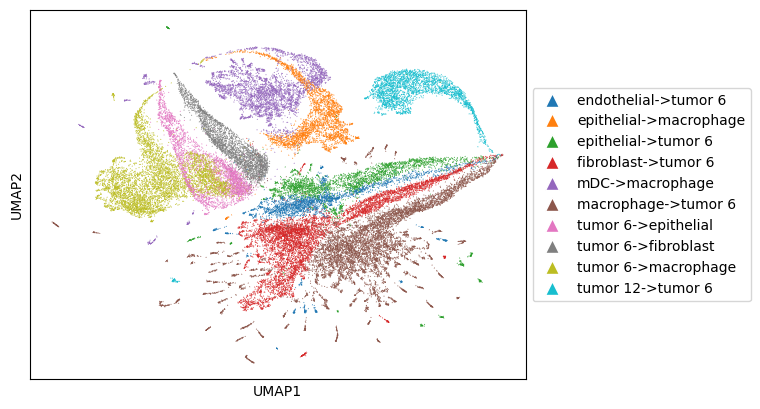

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plotx(adata, marker="^"):
    # Generate the UMAP plot with smaller points (e.g., size=10)
    sc.pl.umap(adata, color='cell_type', title="", show=False, save=False, size=0.2)

    # Access the current figure and axis
    fig = plt.gcf()
    ax = plt.gca()

    # Get the scatter plot and update the marker style
    for artist in ax.collections:
        artist.set_paths([plt.matplotlib.markers.MarkerStyle(marker).get_path()])
        artist.set_offsets(artist.get_offsets())  # Force redraw of the updated markers

    # Modify the legend markers to match the plot markers and move the legend to the right
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [Line2D([0], [0], marker=marker, color='w', markerfacecolor=h.get_facecolor()[0], markersize=10) for h in handles]
    
    ax.legend(handles=new_handles, labels=labels, loc='center left', bbox_to_anchor=(1, 0.5))

    # Show the plot (optional)
    plt.show()

    # Save the plot with the desired filename
    fig.savefig("./figures/CCI_UMAP.pdf", bbox_inches='tight')

# Example call to the function
plotx(adatax)

selecting edge types: ['tumors__tumors' 'fibroblast__fibroblast' 'lymphocyte__neutrophil'
 'neutrophil__tumors' 'fibroblast__neutrophil' 'neutrophil__fibroblast'
 'fibroblast__tumors' 'tumors__neutrophil' 'tumors__fibroblast'
 'neutrophil__lymphocyte']


/tmp/ipykernel_691294/3934911678.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/gpfs/gibbs/project/w

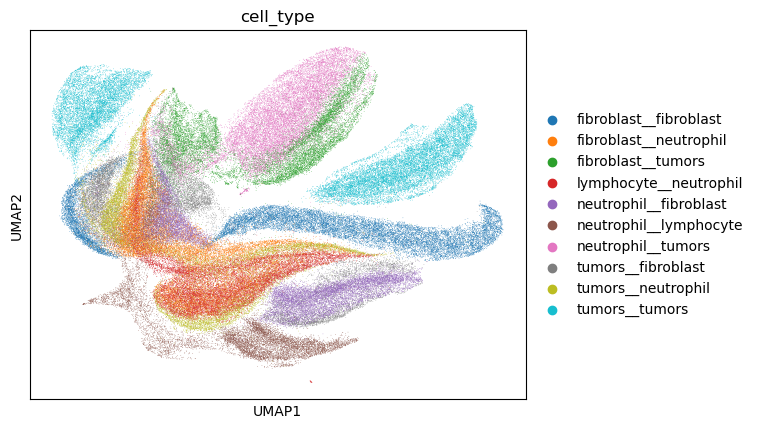

selecting edge types: ['tumors__tumors' 'fibroblast__fibroblast' 'lymphocyte__neutrophil'
 'neutrophil__tumors' 'fibroblast__neutrophil' 'neutrophil__fibroblast'
 'fibroblast__tumors' 'tumors__neutrophil' 'tumors__fibroblast'
 'neutrophil__lymphocyte']


/tmp/ipykernel_691294/3934911678.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
plot(adata,select_type_number=10)
plot(adata,select_type_number=10,color="distance")
unique=np.unique(adata.obs['cell_type'],return_counts=True)
print(unique[0][np.argsort(-unique[1])],unique[1][np.argsort(-unique[1])])

In [4]:
samples=['Lung6', 'Lung5_Rep1', 'Lung5_Rep3', 'Lung5_Rep2', 'Lung9_Rep1', 'Lung9_Rep2', 'Lung12','Lung13']
adata_list=[]
for samplei in samples:
    adata=read_data(samplei,select=5)
    adata_filtered=plot(adata,select_type_number=10)
    plot(adata,color="distance",select_type_number=10)
    adata_list.append(adata)
    
    unique=np.unique(adata.obs['cell_type'],return_counts=True)
    unique=[unique[0][np.argsort(-unique[1])].tolist(),unique[1][np.argsort(-unique[1])].tolist()]
    print(unique)
    torch.save(unique,result_dir+samplei+"_unique_softmax.pth")

merged_adata = sc.concat(adata_list, label="batch")
merged_adata.write('all_3.h5ad')

torch.Size([77025, 99, 960])
torch.return_types.topk(
values=tensor([[0.1673, 0.0943, 0.0747, 0.0709, 0.0696],
        [0.1876, 0.1281, 0.0464, 0.0449, 0.0379],
        [0.1237, 0.0893, 0.0834, 0.0646, 0.0429],
        ...,
        [0.0626, 0.0597, 0.0371, 0.0307, 0.0293],
        [0.2607, 0.0927, 0.0569, 0.0535, 0.0405],
        [0.1129, 0.0882, 0.0380, 0.0368, 0.0353]]),
indices=tensor([[21, 29, 33, 22,  0],
        [21,  0, 53, 12, 26],
        [ 0, 93,  1, 98, 84],
        ...,
        [ 0, 19, 27, 20, 13],
        [66,  1,  2,  0, 40],
        [17,  0,  8,  7, 39]]))
not use edge torch.Size([77025, 99, 960])
number of cell types in this sample: (array(['Mcell', 'endothelial', 'epithelial', 'fibroblast', 'lymphocyte',
       'mast', 'neutrophil', 'tumors'], dtype='<U11'), array([ 6253,  2130,  3536,  2652,  3365,   213,   342, 58534]))
(385125, 960)
selecting edge types: ['tumors__tumors' 'Mcell__tumors' 'fibroblast__tumors'
 'epithelial__tumors' 'endothelial__tumors' 'tumors__Mcel

/tmp/ipykernel_689082/4229705604.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
/gpfs/gibbs/project/wang_zuoheng/xx244/conda_envs/torch/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


KeyboardInterrupt: 

In [ ]:
def plot_all(adata,color='cell_type',select_type_number=None):
    if select_type_number is not None:
        unique=np.unique(adata.obs['cell_type'],return_counts=True)
        args = np.argsort(-unique[1])[:select_type_number]
        select_type = unique[0][args]
        print("selecting edge types:", select_type)
        flag=[adata.obs['cell_type'][i] in select_type for i in range(adata.shape[0])]
        adata_filtered=adata[flag,:]
    else:
        adata_filtered=adata

    sc.pp.scale(adata_filtered)
    sc.tl.pca(adata_filtered, n_comps=40)
    sc.pp.neighbors(adata_filtered)  # Compute the neighborhood graph
    sc.tl.umap(adata_filtered)  # Compute UMAP
    # Plot UMAP
    sc.pl.umap(adata_filtered, color=color)
    return adata_filtered

merged_adata_filtered20=plot_all(merged_adata,select_type_number=20)
merged_adata_filtered10=plot_all(merged_adata,select_type_number=10)
merged_adata_filtered_all=plot_all(merged_adata,select_type_number=None)
merged_adata_filtered20.write('merged_adata_filtered20_3.h5ad')
merged_adata_filtered10.write('merged_adata_filtered10_3.h5ad')
merged_adata_filtered_all.write('merged_adata_filtered_all_3.h5ad')